In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

**Read in data and preprocessing**

In [8]:
df = pd.read_csv("C://Users//JCCLI//Downloads//Chicago_Taxi_Model.csv", \
                usecols = ('trip_miles', 'dropoff_longitude','dropoff_latitude','pickup_latitude','pickup_longitude','trip_minutes','payment_type','company','fare_dollars','month','Week','day','hour','weekday','pick_up_area',\
                          'dropoff_area','Is Holiday', 'Is Snow Day','Is Raining','Is Windy (Gust)', 'Is Windy (Speed)'))

There were some minor errors with setting the locations of dropoff and pickup in Google BigQuery, after looking at area maps using Tableau, some of the pickup and dropoff locations are inaccurate, so I am removing inaccurate locations to avoid errors when training the dataset for deployment later.

In [9]:
df_filtered = df[(df.pickup_longitude >= -87.83)]

In [10]:
df_filtered_2 = df[(df.pickup_longitude <= -87.89)]

In [11]:
df_filtered.head()

,trip_miles,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_dollars,month,day,...,weekday,dropoff_area,pick_up_area,trip_minutes,Week,Is Raining,Is Snow Day,Is Windy (Speed),Is Windy (Gust),Is Holiday
0,4.24,Mobile,Flash Cab,41.870415,-87.675086,41.900266,-87.632109,13.10,6,13,...,Mon,Navy Pier Area,UIC,19.150000,24,0,0,0,1,0
1,0.92,Credit Card,Sun Taxi,41.893216,-87.637844,41.877406,-87.621972,6.25,6,13,...,Mon,Soldier Field/Grant Park,Navy Pier Area,6.800000,24,0,0,0,1,0
2,12.17,Credit Card,Flash Cab,41.975171,-87.687516,41.980264,-87.913625,33.50,6,13,...,Mon,ORD Airport,East Lincolnwood/Wrigley,40.466667,24,0,0,0,1,0
3,1.18,Credit Card,Medallion Leasin,41.893216,-87.637844,41.895033,-87.619711,8.75,6,13,...,Mon,Navy Pier Area,Navy Pier Area,13.950000,24,0,0,0,1,0
4,3.34,Mobile,Sun Taxi,41.938666,-87.711211,41.944227,-87.655998,13.28,6,13,...,Mon,East Lincolnwood/Wrigley,Humboldt Park Area,19.216667,24,0,0,0,1,0


In [12]:
df_filtered_2.head()

,trip_miles,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare_dollars,month,day,...,weekday,dropoff_area,pick_up_area,trip_minutes,Week,Is Raining,Is Snow Day,Is Windy (Speed),Is Windy (Gust),Is Holiday
223,5.65,Credit Card,Flash Cab,41.980264,-87.913625,NaN,NaN,16.75,6,13,...,Mon,Loyola/Edgewater,ORD Airport,13.300000,24,0,0,0,1,0
224,0.90,Cash,Taxi Affiliation Services,41.980264,-87.913625,41.922686,-87.649489,40.75,6,13,...,Mon,Navy Pier Area,ORD Airport,54.000000,24,0,0,0,1,0
225,15.60,Credit Card,KOAM Taxi Association,41.980264,-87.913625,41.944227,-87.655998,42.50,6,13,...,Mon,East Lincolnwood/Wrigley,ORD Airport,56.000000,24,0,0,0,1,0
226,19.34,Credit Card,Flash Cab,41.980264,-87.913625,41.874005,-87.663518,48.25,6,13,...,Mon,UIC,ORD Airport,50.200000,24,0,0,0,1,0
227,14.82,Credit Card,Star North Taxi Management Llc,41.980264,-87.913625,NaN,NaN,38.25,6,13,...,Mon,Loyola/Edgewater,ORD Airport,28.366667,24,0,0,0,1,0


In [13]:
# merge cleaned dataframes
df_new = pd.concat([df_filtered,df_filtered_2],ignore_index=True)

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954636 entries, 0 to 3954635
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_miles         float64
 1   payment_type       object 
 2   company            object 
 3   pickup_latitude    float64
 4   pickup_longitude   float64
 5   dropoff_latitude   float64
 6   dropoff_longitude  float64
 7   fare_dollars       float64
 8   month              int64  
 9   day                int64  
 10  hour               int64  
 11  weekday            object 
 12  dropoff_area       object 
 13  pick_up_area       object 
 14  trip_minutes       float64
 15  Week               int64  
 16  Is Raining         int64  
 17  Is Snow Day        int64  
 18  Is Windy (Speed)   int64  
 19  Is Windy (Gust)    int64  
 20  Is Holiday         int64  
dtypes: float64(7), int64(9), object(5)
memory usage: 633.6+ MB


In [15]:
df_new['month'] = df_new['month'].astype('int64')
df_new['day'] = df_new['day'].astype('int64')
df_new['hour'] = df_new['hour'].astype('int64')
#df_new['trip_end_dt'] = pd.to_datetime(df_new['trip_end_dt'])
#df_new['Week'] = df_new_full['trip_end_dt'].dt.isocalendar().week

In [16]:
df_new['Is Holiday'].value_counts().head(35)

Is Holiday
0    3869702
1      84934
Name: count, dtype: int64

**Feature Engineering**

In [17]:
# Hard code in 2022 Chicago weekly gas prices
def func(x):
    if x == 52:
        return 3.251
    elif x == 51:
        return 3.334
    elif x == 50:
        return 3.469
    elif x == 49:
        return 3.659
    elif x == 48:
        return 3.899
    elif x == 47:
        return 4.08
    elif x == 46:
        return 4.264
    elif x == 45:
        return 4.482
    elif x == 44:
        return 4.266
    elif x == 43:
        return 4.36
    elif x == 42:
        return 4.462
    elif x == 41:
        return 4.558
    elif x == 40:
        return 4.248
    elif x == 39:
        return 4.1
    elif x == 38:
        return 4.076
    elif x == 37:
        return 4.212
    elif x == 36:
        return 4.32
    elif x == 35:
        return 4.373
    elif x == 34:
        return 4.459
    elif x == 33:
        return 4.499
    elif x == 32:
        return 4.659
    elif x == 31:
        return 4.854
    elif x == 30:
        return 5.046
    elif x == 29:
        return 5.238
    elif x == 28:
        return 5.372
    elif x == 27:
        return 5.536
    elif x == 26:
        return 5.647
    elif x == 25:
        return 5.742
    elif x == 24:
        return 5.803
    elif x == 25:
        return 5.579
    elif x == 24:
        return 5.264
    elif x == 23:
        return 5.133
    elif x == 22:
        return 4.929
    elif x == 21:
        return 4.672
    elif x == 20:
        return 4.467
    elif x == 19:
        return 4.447
    elif x == 18:
        return 4.39
    elif x == 17:
        return 4.411
    elif x == 16:
        return 4.473
    elif x == 15:
        return 4.535
    elif x == 14:
        return 4.531
    elif x == 13:
        return 4.57
    elif x == 12:
        return 4.403
    elif x == 11:
        return 3.921
    elif x == 10:
        return 3.722
    elif x == 9:
        return 3.681
    elif x == 8:
        return 3.62
    elif x == 7:
        return 3.514
    elif x == 6:
        return 3.444
    elif x == 5:
        return 3.404
    elif x == 4:
        return 3.457
    elif x == 3:
        return 3.32
    elif x == 2:
        return 3.34
    else:
        return 3.30
df_new['Weekly Gas Price'] = df_new['Week'].apply(func)

In [18]:
df_new = df_new[(df_new.fare_dollars < 120)
               ]

In [19]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3953801 entries, 0 to 3954635
Data columns (total 22 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_miles         float64
 1   payment_type       object 
 2   company            object 
 3   pickup_latitude    float64
 4   pickup_longitude   float64
 5   dropoff_latitude   float64
 6   dropoff_longitude  float64
 7   fare_dollars       float64
 8   month              int64  
 9   day                int64  
 10  hour               int64  
 11  weekday            object 
 12  dropoff_area       object 
 13  pick_up_area       object 
 14  trip_minutes       float64
 15  Week               int64  
 16  Is Raining         int64  
 17  Is Snow Day        int64  
 18  Is Windy (Speed)   int64  
 19  Is Windy (Gust)    int64  
 20  Is Holiday         int64  
 21  Weekly Gas Price   float64
dtypes: float64(8), int64(9), object(5)
memory usage: 693.8+ MB


## Modeling

### Preprocessing

- Before we do modeling, we need to decide which variables to keep and which ones to drop. We will mainly first drop variables that won't be useful in the model. Since we are wanting to deploy our model on the web to be used by users to make better trip decisions, we want to drop any variables that aren't accounted for and are not known until the actual trip. These variables are:
    - 1. pickup longitude
    - 2. pickup latitude
    - 3. dropoff latitude
    - 4. dropoff longitude
    - 5. Is Raining
    - 6. Is Windy (Gust)
    - 7. Is Windy (Speed)
- We are removing some weather variables as most variables don't have an effect at all on fare rate except for if it is a snow  day or not.

- After than we will get rid of any non-relevant variables and also consider removing variables from model depending on if issues exist such as large multicollinearity between variables.

**Removal of non-important variables and encoding categorical features**

In [20]:
df_model = df_new.drop(['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude', 'Is Raining', 'Is Windy (Gust)', 'Is Windy (Speed)'],axis=1)

In [21]:
df_model.head()

,trip_miles,payment_type,company,fare_dollars,month,day,hour,weekday,dropoff_area,pick_up_area,trip_minutes,Week,Is Snow Day,Is Holiday,Weekly Gas Price
0,4.24,Mobile,Flash Cab,13.10,6,13,16,Mon,Navy Pier Area,UIC,19.150000,24,0,0,5.803
1,0.92,Credit Card,Sun Taxi,6.25,6,13,16,Mon,Soldier Field/Grant Park,Navy Pier Area,6.800000,24,0,0,5.803
2,12.17,Credit Card,Flash Cab,33.50,6,13,16,Mon,ORD Airport,East Lincolnwood/Wrigley,40.466667,24,0,0,5.803
3,1.18,Credit Card,Medallion Leasin,8.75,6,13,16,Mon,Navy Pier Area,Navy Pier Area,13.950000,24,0,0,5.803
4,3.34,Mobile,Sun Taxi,13.28,6,13,16,Mon,East Lincolnwood/Wrigley,Humboldt Park Area,19.216667,24,0,0,5.803


**Dummy variable creation for categorical variables**

In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3953801 entries, 0 to 3954635
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   trip_miles        float64
 1   payment_type      object 
 2   company           object 
 3   fare_dollars      float64
 4   month             int64  
 5   day               int64  
 6   hour              int64  
 7   weekday           object 
 8   dropoff_area      object 
 9   pick_up_area      object 
 10  trip_minutes      float64
 11  Week              int64  
 12  Is Snow Day       int64  
 13  Is Holiday        int64  
 14  Weekly Gas Price  float64
dtypes: float64(4), int64(6), object(5)
memory usage: 482.6+ MB


**Converting Categorical Variables using Label Encoding**

In [23]:
# Including wind, and company variables
le = preprocessing.LabelEncoder()
df_model['weekday'] = le.fit_transform(df_model['weekday'])
df_model['company'] = le.fit_transform(df_model['company'])
df_model['pick_up_area'] = le.fit_transform(df_model['pick_up_area'])
df_model['dropoff_area'] = le.fit_transform(df_model['dropoff_area'])

In [24]:
df_model.head(10000)

,trip_miles,payment_type,company,fare_dollars,month,day,hour,weekday,dropoff_area,pick_up_area,trip_minutes,Week,Is Snow Day,Is Holiday,Weekly Gas Price
0,4.24,Mobile,16,13.10,6,13,16,1,16,20,19.150000,24,0,0,5.803
1,0.92,Credit Card,27,6.25,6,13,16,1,18,16,6.800000,24,0,0,5.803
2,12.17,Credit Card,16,33.50,6,13,16,1,17,5,40.466667,24,0,0,5.803
3,1.18,Credit Card,21,8.75,6,13,16,1,16,16,13.950000,24,0,0,5.803
4,3.34,Mobile,27,13.28,6,13,16,1,5,11,19.216667,24,0,0,5.803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,1.11,Cash,16,8.25,3,5,14,2,18,16,12.616667,9,0,0,3.681
9999,17.20,Credit Card,27,42.50,3,5,14,2,17,18,31.000000,9,0,0,3.681
10000,1.13,Mobile,27,8.00,3,5,14,2,18,18,9.783333,9,0,0,3.681
10001,2.50,Credit Card,28,9.50,3,5,14,2,18,18,9.000000,9,0,0,3.681


#### Check label encodes for dictionary (Used for deployment purposes later)

In [25]:
df_model['weekday'].value_counts().head(10)

weekday
0    628448
4    622404
6    614554
5    596975
1    547835
2    500843
3    442742
Name: count, dtype: int64

In [24]:
df_model['company'].value_counts().head(45)

16    855107
28    804801
27    444388
15    392422
12    208997
29    179061
21    172540
17    161576
30    144360
26    101068
9      99735
6      87733
14     79086
32     59713
0      37081
33     36356
10     18406
13     13043
23     12214
19      8815
2       6315
25      4812
18      3527
24      3126
22      2936
31      2911
3       1693
8       1151
1       1020
20       935
7        704
5        655
4         69
11         1
Name: company, dtype: int64

In [25]:
df_cleaned['company'].value_counts().head(35)

Flash Cab                               855107
Taxi Affiliation Services               804801
Sun Taxi                                444388
City Service                            392422
Chicago Independents                    208997
Taxicab Insurance Agency Llc            179061
Medallion Leasin                        172540
Globe Taxi                              161576
Taxicab Insurance Agency, LLC           144360
Star North Taxi Management Llc          101068
Blue Ribbon Taxi Association             99735
5 Star Taxi                              87733
Choice Taxi Association                  79086
Top Cab Affiliation                      59713
24 Seven Taxi                            37081
U Taxicab                                36356
Blue Ribbon Taxi Association Inc.        18406
Chicago Taxicab                          13043
Patriot Taxi Dba Peace Taxi Associat     12214
Koam Taxi Association                     8815
312 Medallion Management Corp             6315
Setare Inc   

In [146]:
df_cleaned['weekday'].value_counts().head(10)

Fri    626233
Thu    620477
Wed    613531
Tue    595762
Mon    547357
Sat    500475
Sun    442522
Name: weekday, dtype: int64

In [20]:
df_cleaned['dropoff_area'].value_counts().head(25)

Navy Pier Area                    992203
Soldier Field/Grant Park          700537
East Lincolnwood/Wrigley          417662
Loyola/Edgewater                  389474
UIC                               334579
ORD Airport                       253224
Humboldt Park Area                220688
Grand Boulevard/IIT               122891
South Lincolnwood/Norridge        100528
MDW Airport                        77606
Chatham/Windsor Park Area          71882
UOC                                68927
Englewood Area                     48579
Lawndale/Canalport                 27616
Evergreen Park/South Englewood     27433
Glendale/New City Area             24143
CSU Area                           22136
Calumet Park/East Side             14720
Garfield Park                       9846
Morgan Park Area                    8876
Calumet Heights Area                8341
Dolton Area                         4466
Name: dropoff_area, dtype: int64

In [23]:
df_cleaned['pick_up_area'].value_counts()

Navy Pier Area                    962957
ORD Airport                       854537
Soldier Field/Grant Park          760481
UIC                               320474
East Lincolnwood/Wrigley          297003
MDW Airport                       159564
Grand Boulevard/IIT               101624
Humboldt Park Area                 94509
Chatham/Windsor Park Area          64575
South Lincolnwood/Norridge         64495
UOC                                52142
Loyola/Edgewater                   51594
Englewood Area                     41835
Evergreen Park/South Englewood     24201
CSU Area                           19182
Calumet Park/East Side             19020
Glendale/New City Area             15141
Lawndale/Canalport                 13824
Morgan Park Area                    8789
Calumet Heights Area                7735
Dolton Area                         6743
Garfield Park                       5932
Name: pick_up_area, dtype: int64

In [24]:
df_model['pick_up_area'].value_counts()

16    962957
17    854537
18    760481
20    320474
5     297003
14    159564
10    101624
11     94509
3      64575
19     64495
21     52142
13     51594
6      41835
7      24201
0      19182
2      19020
9      15141
12     13824
15      8789
1       7735
4       6743
8       5932
Name: pick_up_area, dtype: int64

In [22]:
df_model['dropoff_area'].value_counts()

16    992203
18    700537
5     417662
13    389474
20    334579
17    253224
11    220688
10    122891
19    100528
14     77606
3      71882
21     68927
6      48579
12     27616
7      27433
9      24143
0      22136
2      14720
8       9846
15      8876
1       8341
4       4466
Name: dropoff_area, dtype: int64

In [26]:
# Remove unimportant variables (excluding company and wind)
df_model = df_model.drop(['payment_type'],axis=1)

(array([104715., 141652.,  45843., 188065.,  55203.,  62895., 141120.,
         67479.,      0.,      0., 112427.,      0., 154638.,  94811.,
             0., 356632.,  82409., 245522., 419178., 335051., 314052.,
             0., 167772.,      0.,      0.,  84035.,  92101.,      0.,
         85548.,  93519.,      0.,  85583.,      0.,  88617.,      0.,
         71008.,      0.,  79585.,      0., 184341.]),
 array([3.251 , 3.3148, 3.3786, 3.4424, 3.5062, 3.57  , 3.6338, 3.6976,
        3.7614, 3.8252, 3.889 , 3.9528, 4.0166, 4.0804, 4.1442, 4.208 ,
        4.2718, 4.3356, 4.3994, 4.4632, 4.527 , 4.5908, 4.6546, 4.7184,
        4.7822, 4.846 , 4.9098, 4.9736, 5.0374, 5.1012, 5.165 , 5.2288,
        5.2926, 5.3564, 5.4202, 5.484 , 5.5478, 5.6116, 5.6754, 5.7392,
        5.803 ]),
 <BarContainer object of 40 artists>)

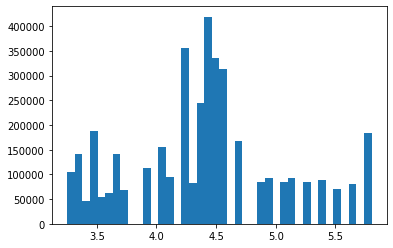

In [27]:
plt.hist(df_model['Weekly Gas Price'], bins = 40)

### Train/Test Split

In [28]:
# Set up target variable and features
target = df_model['fare_dollars']
features = df_model[['trip_miles','trip_minutes','company','month','Week','day','hour','weekday','dropoff_area','pick_up_area',\
                   'Is Holiday','Is Snow Day','Weekly Gas Price']]

In [29]:
# Split up data into train and test set (Try 80/20 first)
train_features, test_features, train_target, test_target = train_test_split(features,
                                                                           target,
                                                                           test_size=0.2,
                                                                           random_state=31)

In [30]:
# Create RMSE variable
def rmse(target,predictors):
    return sqrt(mean_squared_error(target, predictors))

### Model 1: Linear Regression

In [31]:
LR = LinearRegression()
LR = LR.fit(train_features,train_target)
y_pred_test = LR.predict(test_features)
y_pred_train = LR.predict(train_features)
print("Train R^2:", LR.score(train_features,train_target))
print("Test R^2:", LR.score(test_features,test_target))
print("Train RMSE:",rmse(train_target,y_pred_train))
print("Test RMSE:",rmse(test_target,y_pred_test))

Train R^2: 0.8592961813408254
Test R^2: 0.8572320626159333
Train RMSE: 5.873849002271189
Test RMSE: 5.910194343703643


While there is a tiny bit of overfitting here, the difference is not too bad as they are almost the same. We should check model diagnostics first to see if linear regression is the best model to use in our scenario.

In [32]:
prediction = LR.predict(test_features)
residual = (test_target - prediction)

In [33]:
df_res = (test_target,prediction)
df_res

(1452731    10.75
 3012462     6.50
 551804     45.50
 1515134    48.50
 766969     30.00
            ...  
 2409398    62.00
 978674      4.75
 2793108    27.50
 1130817     8.00
 1685606    16.00
 Name: fare_dollars, Length: 790761, dtype: float64,
 array([13.43278631,  9.08801572, 45.23502407, ..., 26.51810617,
         9.72427001, 19.5793801 ]))

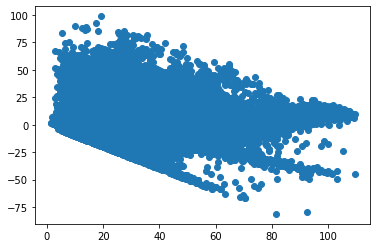

In [34]:
plt.scatter(prediction,residual)

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_8188\1108040850.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: xlabel='fare_dollars', ylabel='Density'>

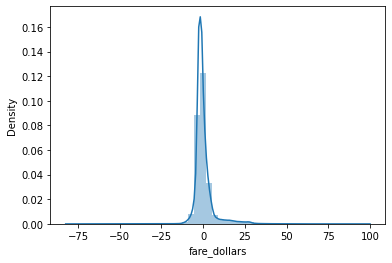

In [35]:
sns.distplot(residual)

In [38]:
# Check VIF to determine multicollinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
pip install statsmodels


  Using cached statsmodels-0.13.5-cp39-cp39-win_amd64.whl (9.2 MB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)


In [39]:
X_Variables = df_model[['trip_miles','trip_minutes','Weekly Gas Price']] 

In [40]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_Variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_Variables.values, i) for i in range(len(X_Variables.columns))]

In [41]:
vif_data

,feature,VIF
0,trip_miles,4.167029
1,trip_minutes,6.240675
2,Weekly Gas Price,3.410655


Nothing that alarming. There is a VIF greater than 5 for trip minutes but it isn't that big of a deal since it's only about 6 and it's at least below 10 since then it would be more of an issue.

**Model 1: Transformations**

If we are going to try using linear regression, let's compare our results if we square root transform our response and some of the predictors

In [42]:
df_model['trip_miles_sqrt'] = np.sqrt(df_model.trip_miles)

In [43]:
df_model['trip_minutes_sqrt'] = np.sqrt(df_model.trip_minutes)

In [44]:
target_sqrt = np.sqrt(df_model.fare_dollars)

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_8188\4040702826.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model['trip_miles_sqrt'])


<Axes: xlabel='trip_miles_sqrt', ylabel='Density'>

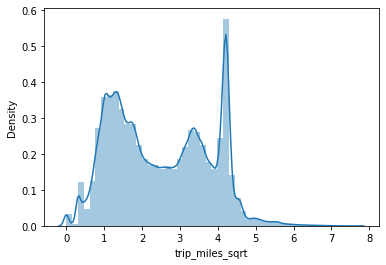

In [45]:
sns.distplot(df_model['trip_miles_sqrt'])

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_8188\1656584234.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model['trip_minutes_sqrt'])


<Axes: xlabel='trip_minutes_sqrt', ylabel='Density'>

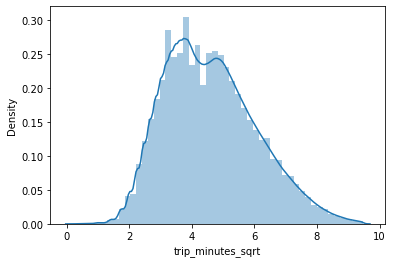

In [46]:
sns.distplot(df_model['trip_minutes_sqrt'])

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_8188\171246675.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_sqrt)


<Axes: xlabel='fare_dollars', ylabel='Density'>

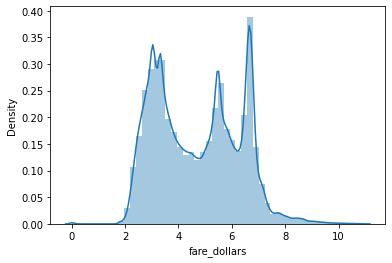

In [47]:
sns.distplot(target_sqrt)

In [48]:
 features_trans = df_model[['trip_miles_sqrt','trip_minutes_sqrt','company','month','Week','day','hour','weekday','dropoff_area','pick_up_area',\
                   'Is Holiday','Is Snow Day', 'Weekly Gas Price']]

In [49]:
train_features_trans, test_features_trans, train_target_trans, test_target_trans = train_test_split(features_trans,
                                                                           target_sqrt,
                                                                           test_size=0.2,
                                                                           random_state=41)

#### Linear Regression with transformed response

In [50]:
LR = LinearRegression()
LR = LR.fit(train_features_trans,train_target_trans)
y_pred_test_trans = LR.predict(test_features_trans)
y_pred_train_trans = LR.predict(train_features_trans)
print("Train R^2:", LR.score(train_features_trans,train_target_trans))
print("Test R^2:", LR.score(test_features_trans,test_target_trans))
print("Train RMSE:",rmse(train_target_trans,y_pred_train_trans))
print("Test RMSE:",rmse(test_target_trans,y_pred_test_trans))

Train R^2: 0.8493910264008423
Test R^2: 0.8490555675336059
Train RMSE: 0.6117207818625163
Test RMSE: 0.6129228942825679


In [51]:
prediction_trans = LR.predict(test_features_trans)
residual_trans = (test_target_trans - prediction_trans)

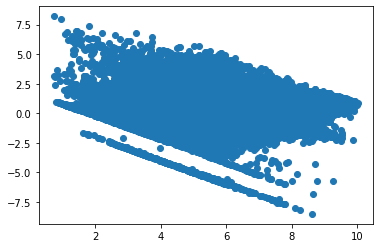

In [52]:
plt.scatter(prediction_trans,residual_trans)

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_8188\1045904564.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual_trans)


<Axes: xlabel='fare_dollars', ylabel='Density'>

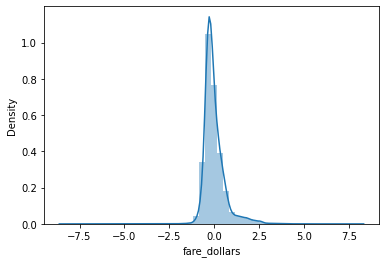

In [53]:
sns.distplot(residual_trans)

While this regression model shows really good performance and no evidence of large overfitting or underfitting, it does look like there is presence of either multicollinearity or non-independence according to the residual vs fitted plot. Let's compare the performance with a few other machine learning algorithms that are more flexible with our type of data. We will use tree-based algorithms since they can handle skewed data and multicollinearity along with other issues a lot better.

**Model 2: Regression Tree**

*Find Optimal Depth*

In [54]:
%%time
dicc_rt={}
for depth in range(2,12):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_rt = DecisionTreeRegressor(max_depth=depth,random_state=20)
    
    # We fit the model
    taxi_model_rt.fit(train_features, train_target)
    
    # We predict train and validation
    train_predictions = taxi_model_rt.predict(train_features)
    test_predictions = taxi_model_rt.predict(test_features)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_test = rmse(test_target, test_predictions)
    difference = error_test - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_rt[str(depth)]= [error_train,error_test,difference]
    print ('For a %d depth the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,error_train,error_test,difference)) 

Depth: 2
For a 2 depth the RMSE_train is 7.12901 $, the RMSE_val is 7.12188 $ and the difference -0.00713 $
Depth: 3
For a 3 depth the RMSE_train is 5.54157 $, the RMSE_val is 5.54225 $ and the difference 0.00067 $
Depth: 4
For a 4 depth the RMSE_train is 4.66470 $, the RMSE_val is 4.66395 $ and the difference -0.00075 $
Depth: 5
For a 5 depth the RMSE_train is 4.08145 $, the RMSE_val is 4.08010 $ and the difference -0.00135 $
Depth: 6
For a 6 depth the RMSE_train is 3.70370 $, the RMSE_val is 3.70728 $ and the difference 0.00359 $
Depth: 7
For a 7 depth the RMSE_train is 3.40698 $, the RMSE_val is 3.42857 $ and the difference 0.02159 $
Depth: 8
For a 8 depth the RMSE_train is 3.23653 $, the RMSE_val is 3.26479 $ and the difference 0.02826 $
Depth: 9
For a 9 depth the RMSE_train is 3.07738 $, the RMSE_val is 3.10549 $ and the difference 0.02811 $
Depth: 10
For a 10 depth the RMSE_train is 2.96527 $, the RMSE_val is 3.01681 $ and the difference 0.05153 $
Depth: 11
For a 11 depth the RMS

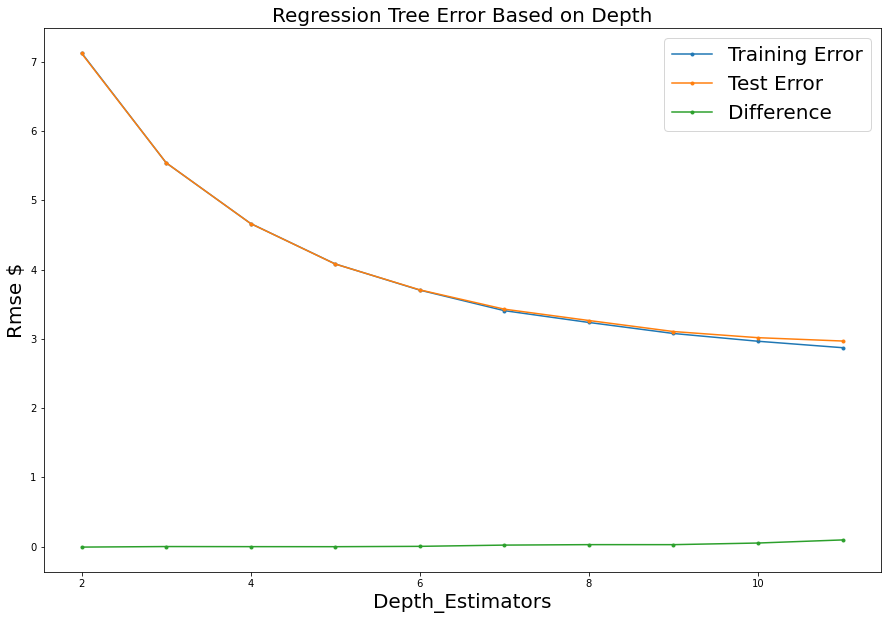

In [55]:
# We convert the dictionary to Dataframe
rt_df = pd.DataFrame.from_dict(dicc_rt).T
rt_df.columns=['Training Error','Test Error','Difference']
ax = rt_df.plot(kind='line', style='.-',figsize=(15,10))
ax.set_title('Regression Tree Error Based on Depth', fontsize=20)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

The best depth would be 6 since it has the lowest RMSE with no underfitting and the lowest amount of overfitting as well.

In [56]:
# Train the model using the set depth
RT = DecisionTreeRegressor(random_state =20,max_depth = 6)

# Train Decision Tree Regressor
RT = RT.fit(train_features,train_target)

#Predict the response for test dataset
y_predtrain = RT.predict(train_features)
y_predtest = RT.predict(test_features)
print("Train R^2:",RT.score(train_features,train_target))
print("Test R^2:", RT.score(test_features,test_target))
print("Train RMSE:", rmse(train_target,y_predtrain))
print("Test RMSE:", rmse(test_target,y_predtest))

Train R^2: 0.9440589311830924
Test R^2: 0.9438256123423466
Train RMSE: 3.7036950047940036
Test RMSE: 3.7072817463901537


The RMSE and R^2 values have definitely improved and has way less overfitting than linear regression. Let's try boosting methods such as LightGBM and XGBoost.

**Model 3: LightGBM**

In [57]:
%%time
dicc_lgbm={}
for depth in range(2,8):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_lgbm = LGBMRegressor(max_depth=depth,random_state=40)
    
    # We fit the model
    taxi_model_lgbm.fit(train_features, train_target)
    
    # We predict train and validation
    train_predictions = taxi_model_lgbm.predict(train_features)
    test_predictions = taxi_model_lgbm.predict(test_features)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_test = rmse(test_target, test_predictions)
    difference = error_test - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_lgbm[str(depth)]= [error_train,error_test,difference]
    print ('For a %d depth the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,error_train,error_test,difference)) 

Depth: 2
For a 2 depth the RMSE_train is 4.28293 $, the RMSE_val is 4.30058 $ and the difference 0.01766 $
Depth: 3
For a 3 depth the RMSE_train is 3.64664 $, the RMSE_val is 3.65655 $ and the difference 0.00991 $
Depth: 4
For a 4 depth the RMSE_train is 3.33197 $, the RMSE_val is 3.34033 $ and the difference 0.00837 $
Depth: 5
For a 5 depth the RMSE_train is 3.08683 $, the RMSE_val is 3.09552 $ and the difference 0.00869 $
Depth: 6
For a 6 depth the RMSE_train is 2.97370 $, the RMSE_val is 2.98314 $ and the difference 0.00945 $
Depth: 7
For a 7 depth the RMSE_train is 2.93063 $, the RMSE_val is 2.94448 $ and the difference 0.01384 $
CPU times: total: 12min 17s
Wall time: 4min 28s


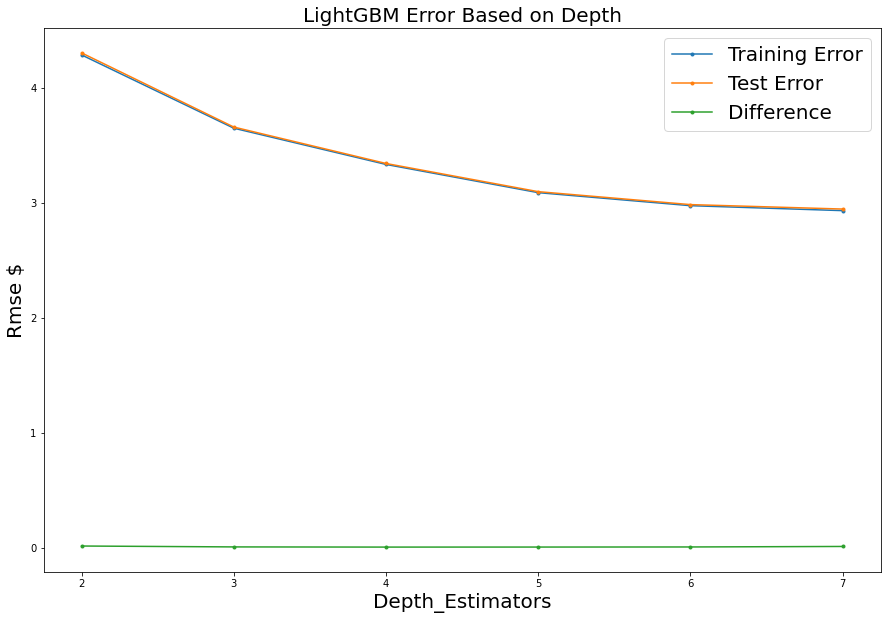

In [58]:
lgbm_df = pd.DataFrame.from_dict(dicc_lgbm).T
lgbm_df.columns=['Training Error','Test Error','Difference']
ax = lgbm_df.plot(kind='line', style='.-',figsize=(15,10))
ax.set_title('LightGBM Error Based on Depth', fontsize=20)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

In [59]:
GBMRegressor = LGBMRegressor(random_state = 43, max_depth= 4)


GBMRegressor = GBMRegressor.fit(train_features,train_target)


y_predtrain = GBMRegressor.predict(train_features)
y_predtest = GBMRegressor.predict(test_features)
print("Train R^2:",GBMRegressor.score(train_features,train_target))
print("Test R^2:", GBMRegressor.score(test_features,test_target))
print("Train RMSE:", rmse(train_target,y_predtrain))
print("Test RMSE:", rmse(test_target,y_predtest))

Train R^2: 0.9552569425131467
Test R^2: 0.9549728672500635
Train RMSE: 3.3123228829988243
Test RMSE: 3.319124673150135


**Model 4: XGBoost**

In [67]:
%%time
dicc_dt={}
for depth in range(4,6):
    print('Depth: %d' % (depth))
    
    # We train the model
    taxi_model_xgb = XGBRegressor(max_depth=depth,random_state=40)
    
    # We fit the model
    taxi_model_xgb.fit(train_features, train_target)
    
    # We predict train and validation
    train_predictions = taxi_model_xgb.predict(train_features)
    test_predictions = taxi_model_xgb.predict(test_features)
    
    # We get the errors
    error_train = rmse(train_target, train_predictions)
    error_test = rmse(test_target, test_predictions)
    difference = error_test - error_train
    
    # We save the errors and the difference in a dictionary
    dicc_dt[str(depth)]= [error_train,error_test,difference]
    print ('For depth of %d, the train RMSE is %.5f $, and the test RMSE is %.5f $ and the difference %.5f $'
               % (depth,error_train,error_test,difference)) 

Depth: 4
For depth of 4, the train RMSE is 3.08744 $, and the test RMSE is 3.09970 $ and the difference 0.01226 $
Depth: 5
For depth of 5, the train RMSE is 2.89521 $, and the test RMSE is 2.92606 $ and the difference 0.03085 $
CPU times: total: 43min 55s
Wall time: 12min 32s


In [70]:
xgb_df = pd.DataFrame.from_dict(dicc_dt).T
xgb_df.columns=['Training Error','Test Error','Difference']

In [71]:
xgb_df

,Training Error,Test Error,Difference
4,3.087443,3.099700,0.012258
5,2.895212,2.926064,0.030852


In [72]:
Regressor = XGBRegressor(random_state = 43, max_depth = 3)


Regressor = Regressor.fit(train_features,train_target)


y_predtrain = Regressor.predict(train_features)
y_predtest = Regressor.predict(test_features)
print("Train R^2:",Regressor.score(train_features,train_target))
print("Test R^2:", Regressor.score(test_features,test_target))
print("Train RMSE:", rmse(train_target,y_predtrain))
print("Test RMSE:", rmse(test_target,y_predtest))

Train R^2: 0.9529373104079311
Test R^2: 0.9525406726717167
Train RMSE: 3.3970990310997933
Test RMSE: 3.407589007137152


**Final Model Decision**

Below are the performances of our models:

**Linear Regression**

Train RMSE: 5.87

Test RMSE: 5.91

Train R^2: 85.93%

Test R^2: 85.72%


**Linear Regression with transformation**

Train RMSE: 0.6117

Test RMSE: 0.6129

Train R^2: 84.93%

Test R^2: 84.91%

**Regression Tree**

Train RMSE: 3.7037

Test RMSE:  3.7073

Train R^2: 94.40%

Test R^2: 94.38%

**LightGBM**

 Train RMSE:  3.3123

 Test RMSE:  3.3191 
 
 Train R^2: 95.52%
 
 Test R^2: 95.50%

**XGBoost**

Train RMSE: 3.3971

Test RMSE: 3.4076

Train R^2: 95.29%

Test R^2: 95.25%


Overall, we will pick LightGBM with depth of 4 as the best performing model. It was shown that we could get the RMSE below 3 easily with XGBoost but we could use the same with a higher depth using LightGBM to get less overfitting. And since we want to minimize overfitting, and the fact that we have a great R^2 statistic, we will choose LightGBM over XGBoost.

**Dump final model for deployment**

In [73]:
import pickle

In [74]:
lgbm_pkl_file = 'LightGBM_Chicago_Taxi.pkl'
lgbm_pkl = open(lgbm_pkl_file, 'wb')
pickle.dump(GBMRegressor,lgbm_pkl)
lgbm_pkl.close()